In [ ]:
import os
import glob
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None

## 1. Introduction:

This notebook details the methodology for feature importance permutation of pose-estimation keypoints for sign language recognition. The keypoints used here were extracted using MediaPipe's Holistic package, specifically the Pose and Hands solutions (maps provided below). This extraction results in a total of 75 keypoints, each composed of x, y, and z coordinates. 

<!-- <img src="images/mp_body.png" alt="Pose keypoint visual mapping"/> -->
![See: images/mp_body.png](images/mp_body.png)
<center>Figure 1: MediaPipe Pose keypoint mapping. Ref: <a href=https://github.com/google/mediapipe/blob/master/docs/solutions/pose.md>link</a></center>

<!-- <img src="images/mp_hand.png" alt="Hand keypoint visual mapping"/> -->
![See: images/mp_hand.png](images/mp_hand.png)
<center>Figure 2: MediaPipe Hands keypoint mapping. Ref: <a href=https://github.com/google/mediapipe/blob/master/docs/solutions/hands.md>link</a></center>

A mapping of keypoint to associated body part is provided in misc/kp_map.json. For clarity of reference within this notebook:
 - Keypoint indices 0 - 32 refer to the body pose
 - Keypoint indices 33 - 53 refer to the left hand 
 - Keypoint indices 54 - 74 refer to the right hand 
 

## 2. Model: 

The model architecture used in these experiments is as detailed in [1] and summarised below: 

1. Four stacked 1D convolutional layers with increasing kernel size (3, 5, 7, 9) to learn local temporal patterns for each coordinate individually. Padding added to maintain sequence length. 
2. Embeddings generated independently from each frame in the sequence to learn non-linear relationships between individual keypoint coordinates. This consists of four blocks containing:
    - Linear layer
    - Layer normalisation
    - GeLU activation function (except last block)
    - Dropout (except last block)
3. Similar to first step except that each block now contains two convolutional layers with GeLU activation between them. This step detects local temporal patters within the embedding sequence with a limited receptive field. 
4. Global temporal information is learned using self-attention in which the receptive field covers the entire sequence. 
5. The resulting vector is used as input to the final classification layer. 

<!-- <img src="images/PoseFormer.png" alt="Hand keypoint visual mapping"/> -->
![See: images/PoseFormer.png](images/PoseFormer.png)
<center>Figure 3: Model architecture. Ref: [1]</center>


The same hyperparameters were also used in these experiments and are summarized below: 

| Hyperparameter | Value |
| --- | --- |
| Batch size | 64 |
| No. attention layers | 4 | 
| No. attention heads | 8 |
| Feature size | 134 |
| Embedding size | 192 |
| Initial learning rate | 0.0003 |

Once trained, the model state from the best performing epoch in terms of validation accuracy was used to determine macro F1 scores for the baseline and all permuted runs.

## 3. Keypoint Importance: 

Permutation Feature Importance[2] is a model-agnostic procedure for determining the features that most contribute to the performance of a trained model. The procedure typically involves randomly shuffling the values of the feature of interest in order to remove any association between that independent feature and the target variable. If this feature contributes significantly to correct predictions, this shuffling operation should result in a marked decrease in performance. Conversely, if the decrease in performance is negligible, this suggests that this feature does not contribute significantly to classification decisions. Here, we use this measure of importance with a slight modification which avoids the potentially costly shuffling operation. We, in place of shuffling a given feature, replace it with values drawn uniformly at random within the range of all features in the dataset as shown in the following cells: 

In [5]:
PATH = '/path/to/corpusVGT/keypoint/*.npy'

In [6]:
original_samples = glob.glob(PATH)
print(f'Total number of samples: {len(original_samples)}')

Total number of samples: 24967


### 3.1 Finding the minimum and maximum values: 

In [7]:
minimum = 0
maximum = 0

for arr in original_samples: 
    arr = np.load(arr)
    minval = np.amin(arr)
    maxval = np.amax(arr)
    
    if minval < minimum:
        minimum = minval
    if maxval > maximum:
        maximum = maxval
print(f'Min value: {minimum}; Max value: {maximum}')

Min value: -1.655800461769104; Max value: 2.5463123321533203


### 3.2 The "shuffling" process:

Each sample NumPy array is of shape [t, 75, 3] where: 
 - t is the number of timesteps (i.e. the number of video frames in the sequence)
 - 75 is the number of extracted keypoints
 - 3 is the coordinate dimenstionality (i.e. x, y and z). 
 
Below is a simplified example array of shape [2, 5, 3] to more easily demonstrate our modified "shuffling" process:


In [8]:
simplified_example_arr = np.zeros([2, 5, 3], dtype=float)
print(simplified_example_arr)

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]


In [9]:
example_kp_idx = 2
for timestep in simplified_example_arr:
    timestep[example_kp_idx] = (maximum - minimum)*np.random.rand(3)+minimum
print(simplified_example_arr)

[[[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.22172427 -0.64409121  1.32519808]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.4879384   1.98913562 -0.55352138]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]]


As shown above, for each timestep/frame in the sequence, the x, y and z coordinates for the keypoint at index 2 is replaced with a new value in the given range. 

An example of the full process is shown below: 

In [ ]:
def permute_index(path, idx, minimum=-1.66, maximum=2.55, dst='/path/to/dir/'):
    """
    path: path to file to be permuted
    idx: index of keypoint to be permuted (0-74)
    minimum: lower limit for range of permuted value
    maximum: upper limit for range of permuted value
    dst: new location for permuted file 
    
    Creates permuted copy of original file and saves it in new location.
    """
    name = os.path.basename(path)
    file = np.load(path) #load .npy file
    p_file = file.copy() #create copy to permute

    new_path = os.path.join(dst, name)
    
    #For each time step, permute kps at given index:
    for t in p_file:
        t[idx] = (maximum - minimum)*np.random.rand(3)+minimum
        
    #Save permuted version in given dst:    
    np.save(new_path, p_file)

##### Body Keypoints: 

In [ ]:
# Loop over body keypoints indices 0 - 32:
for kpidx in range(0, 33):
    # Loop over 30 random seeds:
    for i in range(0, 30):
        np.random.seed(i)
        # Loop over the original samples:
        for s in original_samples:
            # Call permutation function:
            permute_index(s, kpidx)
        
        # Run testing script noting both keypoint and seed:
        cmd = f'/path/to/test.py /path/to/model_state.ckpt /path/to/results/body_kp{kpidx}/seed{i}.csv'

        %run $cmd

##### Left Hand Keypoints:

In [ ]:
# Loop over left hand keypoints indices 33 - 53:
for kpidx in range(33, 54):
    # Loop over 30 random seeds:
    for i in range(0, 30):
        np.random.seed(i)
        # Loop over the original samples:
        for s in original_samples:
            # Call permutation function:
            permute_index(s, kpidx)
        
        # Run testing script noting both keypoint and seed:
        cmd = f'/path/to/test.py /path/to/model_state.ckpt /path/to/results/lh_kp{kpidx}/seed{i}.csv'

        %run $cmd

##### Right Hand Keypoints: 

In [ ]:
# Loop over right hand keypoints indices 54 - 74:
for kpidx in range(54, 75):
    # Loop over 30 random seeds:
    for i in range(0, 30):
        np.random.seed(i)
        # Loop over the original samples:
        for s in original_samples:
            # Call permutation function:
            permute_index(s, kpidx)
        
        # Run testing script noting both keypoint and seed:
        cmd = f'/path/to/test.py /path/to/model_state.ckpt /path/to/results/rh_kp{kpidx}/seed{i}.csv'

        %run $cmd

We generate macro averaged F1 scores for the training, validation and testing subsets in each of thse result CSV files. These scores are then averaged over the 30 iterations to produce the following: 

In [12]:
results_df = pd.read_csv('misc/results.csv', index_col='KP')
results_df.head(10)

,train,val,test
KP,,,
baseline,0.6781,0.3245,0.2983
body_kp0,0.3062,0.1582,0.1602
body_kp1,0.4667,0.2332,0.2199
body_kp2,0.4879,0.2430,0.2331
body_kp3,0.4284,0.2243,0.2063
body_kp4,0.4336,0.2172,0.2082
body_kp5,0.4720,0.2331,0.2110
body_kp6,0.4614,0.2257,0.2081
body_kp7,0.2768,0.1523,0.1477


### 3.3 Determining Importance: 
By comparing our results to the established baseline scores we can determine which keypoints had an effect on performance and therefore be deemed "important":

In [13]:
# Baseline scores:
train_base_score = 0.6781
val_base_score = 0.3245
test_base_score = 0.2983

In [14]:
# Showing that keypoints below the hip had no influence on model performance: 
results_df[(results_df['train'] >= 0.6781)|(results_df['val'] >= 0.3245)|(results_df['test'] >= 0.2983)]

,train,val,test
KP,,,
baseline,0.6781,0.3245,0.2983
body_kp25,0.6781,0.3245,0.2983
body_kp26,0.6781,0.3245,0.2983
body_kp27,0.6781,0.3245,0.2983
body_kp28,0.6781,0.3245,0.2983
body_kp29,0.6781,0.3245,0.2983
body_kp30,0.6781,0.3245,0.2983
body_kp31,0.6781,0.3245,0.2983
body_kp32,0.6781,0.3245,0.2983


In [15]:
# Defining new DataFrame of "important" keypoints only:
important = results_df[(results_df['train'] < 0.6781)|(results_df['val'] < 0.3245)|(results_df['test'] < 0.2983)]
print(f'Number of important keypoints: {important.shape[0]}')

Number of important keypoints: 67


As we are most interested in the unseen test subset, the following figures will reference this data only:

In [17]:
# Isolate the test subset:
important_test = important[['test']]

In [18]:
# Separate body and each of the hands:
body = important_test.iloc[:25]
lh = important_test.iloc[25:46]
rh = important_test.iloc[46:]

# Load mapping of keypoint names:
file = open('misc/kp_map.json')
kp_names = json.load(file)

#### Body:

In [25]:
# Calculate the importance score:
body_diff_from_baseline = []

# Loop over each of the important body keypoints:
for i, row in body.iterrows():
    value = row['test']
    diff = test_base_score - value
    body_diff_from_baseline.append(diff)
    
body['importance_score'] = body_diff_from_baseline

body.head()

,test,importance_score
KP,,
body_kp0,0.1602,0.1381
body_kp1,0.2199,0.0784
body_kp2,0.2331,0.0652
body_kp3,0.2063,0.0920
body_kp4,0.2082,0.0901


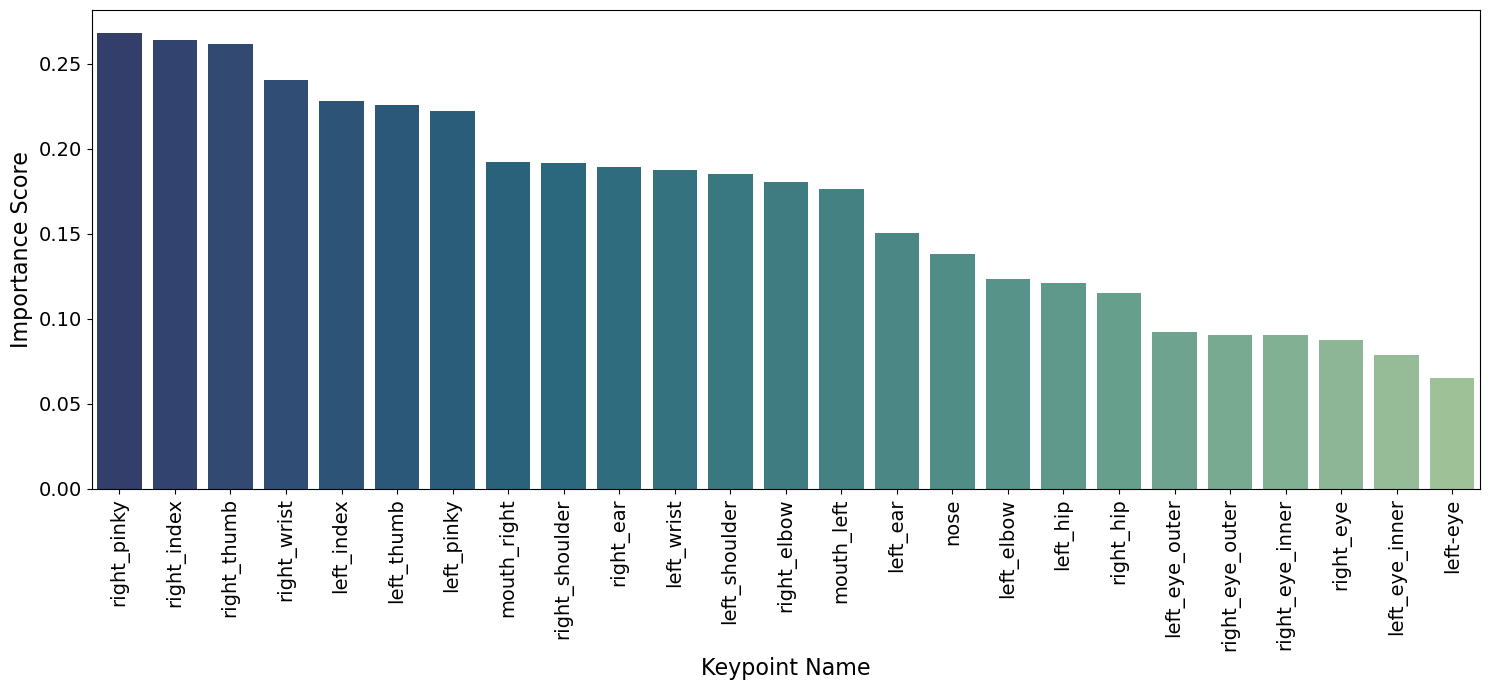

In [28]:
# Create fig of importance scores ordered from most to least important:
fig, ax = plt.subplots(figsize=(15, 7))
pal = sns.color_palette("crest_r", len(body))
sns.barplot(x=body.index, 
            y="importance_score", 
            data=body, 
            order=body.sort_values('importance_score', ascending=False).index, 
            palette=pal)
plt.ylabel('Importance Score', fontsize=16)
plt.xlabel('Keypoint Name', fontsize=16)
new_x_names = [kp_names[x] for x in list(body.sort_values('importance_score', ascending=False).index)]
ax.set_xticklabels(new_x_names)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

#### Left Hand:

In [29]:
# Calculate the importance score:
lh_diff_from_baseline = []

# Loop over each of the important lh keypoints:
for i, row in lh.iterrows():
    value = row['test']
    diff = test_base_score - value
    lh_diff_from_baseline.append(diff)
    
lh['importance_score'] = lh_diff_from_baseline

lh.head()

,test,importance_score
KP,,
lh_kp33,0.2486,0.0497
lh_kp34,0.0196,0.2787
lh_kp35,0.0420,0.2563
lh_kp36,0.0477,0.2506
lh_kp37,0.0185,0.2798


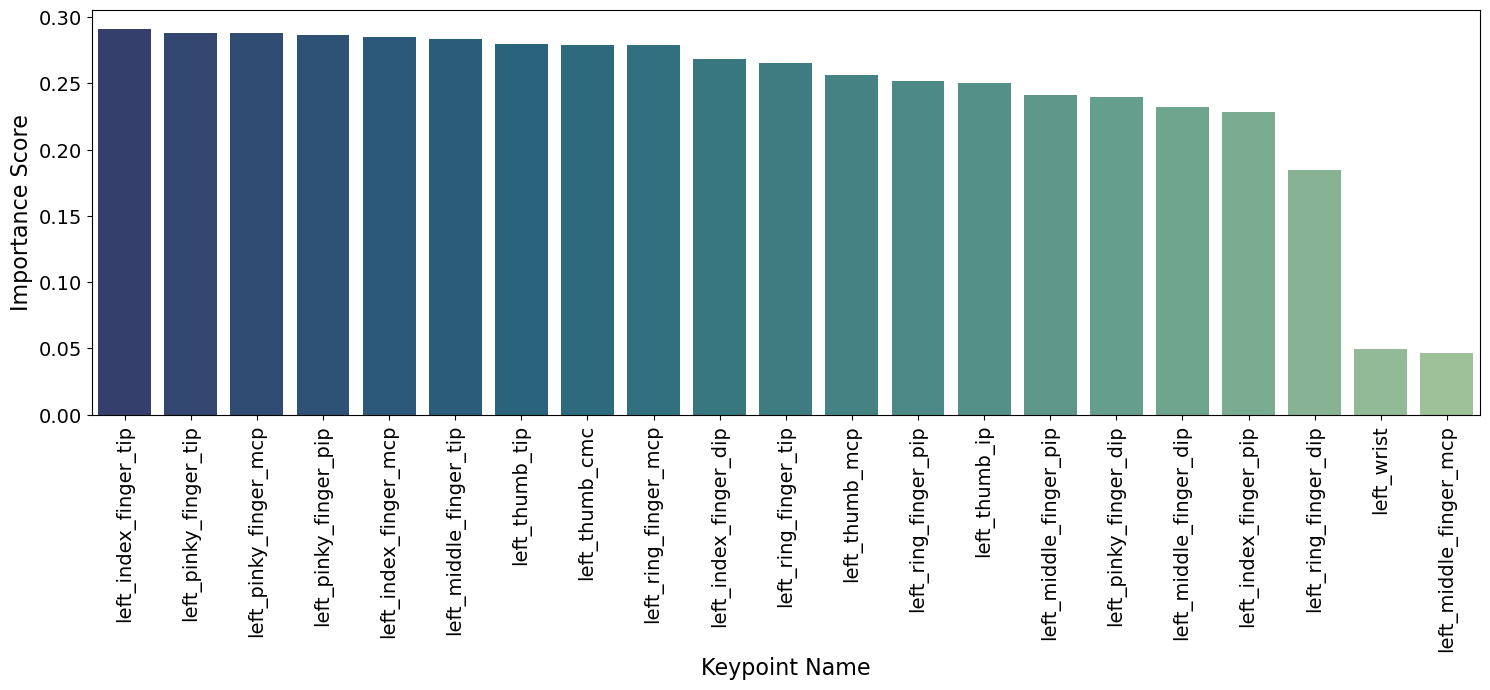

In [31]:
# Create fig of importance scores ordered from most to least important:
fig, ax = plt.subplots(figsize=(15, 7))
pal = sns.color_palette("crest_r", len(lh))
sns.barplot(x=lh.index, 
            y="importance_score", 
            data=lh, 
            order=lh.sort_values('importance_score', ascending=False).index, 
            palette=pal)
plt.ylabel('Importance Score', fontsize=16)
plt.xlabel('Keypoint Name', fontsize=16)
new_x_names = [kp_names[x] for x in list(lh.sort_values('importance_score', ascending=False).index)]
ax.set_xticklabels(new_x_names)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

#### Right Hand:

In [32]:
# Calculate the importance score:
rh_diff_from_baseline = []

# Loop over each of the important rh keypoints:
for i, row in rh.iterrows():
    value = row['test']
    diff = 0.2983 - value
    rh_diff_from_baseline.append(diff)
    
rh['importance_score'] = rh_diff_from_baseline

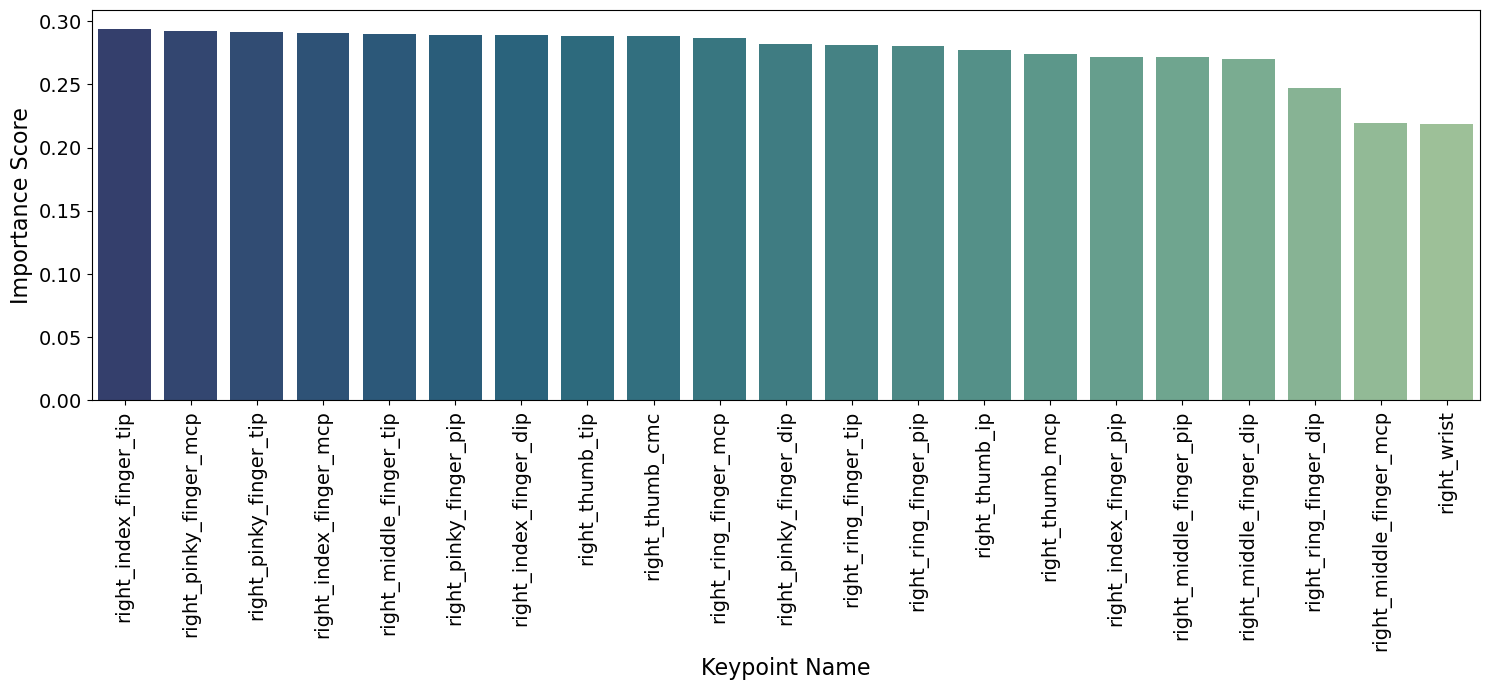

In [33]:
# Create fig of importance scores ordered from most to least important:
fig, ax = plt.subplots(figsize=(15, 7))
pal = sns.color_palette("crest_r", len(rh))
sns.barplot(x=rh.index, 
            y="importance_score", 
            data=rh, 
            order=rh.sort_values('importance_score', ascending=False).index, 
            palette=pal)
plt.ylabel('Importance Score', fontsize=16)
plt.xlabel('Keypoint Name', fontsize=16)
new_x_names = [kp_names[x] for x in list(rh.sort_values('importance_score', ascending=False).index)]
ax.set_xticklabels(new_x_names)
plt.xticks(rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

#### References: 
[1]  Ruth Holmes, Ellen Rushe, Mathieu De Coster, Maxim Bonnaerens, Shin’ichi Satoh, Akihiro Sugimoto, and Anthony Ventresque. 2023. From scarcity to understanding: Transfer learning for the extremely low resource irish sign language. *In Proceedings of the Eleventh International Workshop on Assistive Computer Vision and Robotics, in conjunction with IEEE/CVF International Conference on Computer Vision*, pages 2008–2017.

[2]  Leo Breiman. 2001. Random forests. *Machine learning*, 45:5–32.